In [7]:
import os
import random

import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import retro                 # Retro Environment
from retro.retro_env import RetroEnv

import matplotlib.pyplot as plt # Display graphs
from IPython import display

from collections import deque # Ordered collection with ends

import gym



rom_path = os.path.dirname(os.path.abspath('.')) + '/StreetFighterIISpecialChampionEdition-Genesis'

#scenario_name = 'scenario_sunppang'
scenario_name = 'scenario'

model_path = '/root/sf2-workspace/sf2-env/sf2/models/64_nodes_decay_normal_10000_ep/'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
#log_file = open('./dqn.log', 'w')

### PREPROCESSING HYPERPARAMETERS
#stack_size = 10                 # Number of frames stacked
stack_size = 5
state_element_number = 27

# x축 거리(0~187), y축 거리(0~70), 좌(상대편의 왼쪽), 우(상대편의 오른쪽) (장풍은 제거, TODO: 장풍 state 추가, 공격 범위 추가)
state_size = state_element_number * stack_size
#learning_rate =  0.00025
#learning_rate =  0.0005
learning_rate = 0.005

### TRAINING 관련
total_episodes = 1000            
max_steps = 50000              
batch_size = 64
#batch_size = 1000

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
#decay_rate = 0.00001           # exponential decay rate for exploration prob
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
#gamma = 0.9                    # Discounting rate
gamma = 0.95

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
#memory_size = 1000000          # Number of experiences the Memory can keep
memory_size = 100000

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False




In [8]:



class SF2Env(RetroEnv):
    KEY_LIST = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
    
    
    
    def __init__(self, game, state=retro.State.DEFAULT, scenario=None, info=None, use_restricted_actions=retro.Actions.FILTERED,
                 record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE, press_button_print=False):
        self.recent_action = None
        
        # action 입력은 DISCRETE 모드
        use_restricted_actions = retro.Actions.DISCRETE
        self.press_button_print = press_button_print
        
        RetroEnv.__init__(self, game, state, scenario, info, use_restricted_actions,
                 record, players, inttype, obs_type)
        self.buttons = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
        self.buttons_dict = {}
        for k,v in enumerate(self.buttons):
            self.buttons_dict[v] = k
        
        self.actions = [
            ['LEFT'],
            ['RIGHT'],
            ['UP'],
            ['DOWN'],
            ['LEFT','UP'],
            ['LEFT', 'DOWN'],
            ['RIGHT', 'UP'],
            ['RIGHT', 'DOWN'],
            ['A'],
            ['B'],
            ['C'],
            ['X'],
            ['Y'],
            ['Z'],
            ['DOWN', 'A'],
            ['DOWN', 'B'],
            ['DOWN', 'C'],
            ['DOWN', 'X'],
            ['DOWN', 'Y'],
            ['DOWN', 'Z']
        ]
        
        self.action_space = gym.spaces.Discrete(len(self.actions) ** players)
    
    def step(self, a):
        self.recent_action = a
        reward_sum = 0
        for i in range(5):
            ob, rew, done, info = RetroEnv.step(self, a)
            reward_sum += rew
        
        if self.press_button_print:
            print(self.action_array_to_keys(self.action_to_array(a)))
        
        return self.get_state_from(), reward_sum, done, info
    
    def reset(self):
        RetroEnv.reset(self)
        self.recent_action = None
        return self.get_state_from()
            
    def action_array_to_keys(self, action_array):
        press_keys = []
        for i,v in enumerate(action_array[0]):
            if v == 1:
                press_keys.append(self.KEY_LIST[i])
        return press_keys
    
    def action_to_array(self, a):
        button_array = [0] * 12
        for button in self.actions[a]:
            button_array[self.buttons_dict[button]] = 1
        return [button_array]
        
    
    # env로부터 state 값을 변환
    def get_state_from(self):
        state = []
        
        is_1p_atackking = 1 if int(self.data.lookup_value('is_first_player_atackking')) in [1, 513, 1537] else 0
        is_2p_atackking = 1 if int(self.data.lookup_value('is_second_player_atackking')) in [1, 513, 1537] else 0
        
        is_1p_jumping = 1 if int(self.data.lookup_value('first_player_y')) > 192 else 0
        is_2p_jumping = 1 if int(self.data.lookup_value('second_player_y')) > 192 else 0
        
        first_player_x = int(self.data.lookup_value('first_player_x'))
        second_player_x = int(self.data.lookup_value('second_player_x'))
        left_or_right = 0
        left_or_right = 1 if first_player_x > second_player_x else 0
        if first_player_x > second_player_x:
            left_or_right = 1
        elif first_player_x < second_player_x: 
            left_or_right = -1
        else:
            left_or_right = 0
        
        state.append(int(self.data.lookup_value('distance_x_between_players'))/188)
        state.append(int(self.data.lookup_value('distance_y_between_players'))/71)
        
        #state.append(int(self.data.lookup_value('first_player_attack_x')))
        #state.append(int(self.data.lookup_value('second_player_attack_x')))
        
        state.append(is_1p_jumping)
        state.append(is_2p_jumping)
        
        
        state.append(is_1p_atackking)
        state.append(is_2p_atackking)
        
        state.append(left_or_right)
        
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('continuetimer'))/153) # max 153
        #state.append(int(self.data.lookup_value('first_player_health'))) # range : -1 ~ 176
        #state.append(int(self.data.lookup_value('second_player_health')))
        #state.append(int(self.data.lookup_value('first_player_action_kind')))
        
        # 에이전트의 최근 액션 (20개)
        for j in range(len(self.actions)):
            if self.recent_action == j:
                state.append(1)
            else:
                state.append(0)
        
        return np.asarray(state)


class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.fc = tf.layers.dense(inputs = self.inputs_,
                                  units = 64,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc")
            
            '''
            self.fc2 = tf.layers.dense(inputs = self.fc,
                                  units = 40,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc2")
            '''
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
def stack_frames(stacked_frames, state, is_new_episode):
    frame = state
    
    if is_new_episode:
        # clear stacked_frames
        stacked_frames = deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        for i in range(stack_size-1):
            stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames, axis=1)
        
    else:
        stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames) 
    
    return stacked_state, stacked_frames


            


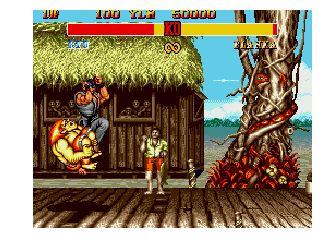

Total reward -149.0
steps 230


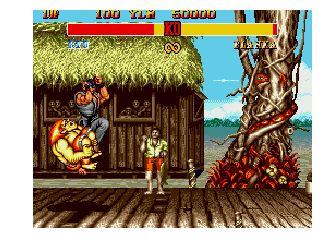

In [9]:
# Reset the graph
tf.reset_default_graph()

env = SF2Env(rom_path, 
                   'ryu_vs_blanka.state', 
                   scenario=scenario_name,
                   players=1,
                   use_restricted_actions=retro.Actions.DISCRETE)

possible_actions = np.array(list(range(0, env.action_space.n)))

# initialize (deque 사용, max 4개 유지)
stacked_frames  =  deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, env.action_space.n, learning_rate)


plt.figure(3)
plt.clf()

saver = tf.train.Saver()


with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, model_path)
    
    for episode in range(3):
        step = 0
        total_rewards = 0
        
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        t = 0
        while True:
            t += 1
            # Reshape the state
            state = state.reshape((1, state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            a_list = [0]*env.action_space.n
            a_list[choice] = 1
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            step += 1
            
            if t % 2 == 0:
                plt.imshow(env.render(mode='rgb_array'))
                plt.axis('off')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            
            total_rewards += reward

            if done:
                print ("Total reward", total_rewards)
                print ("steps", step)
                total_test_rewards.append(total_rewards)
                break
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            next_state = next_state.flatten()
            state = next_state
            
    env.close()

In [ ]:
env.close()


In [ ]:
memory.buffer[0]

In [ ]:
len(memory.buffer)

In [ ]:
import sys
sys.getsizeof(memory)

In [ ]:
env.close()

In [ ]:
sys.getsizeof(memory.buffer)

In [ ]:
sys.getsizeof(' ')